# 라이브러리

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터 가져오기

In [2]:
datapath = "./data/winequalityN.csv"

data_sets = pd.read_csv(datapath, delimiter = ',')

data_sets.dropna(inplace = True)

x_data = data_sets.drop(columns = ["type", "quality"],axis = 1)
# x_data = x_data[['volatile acidity','alcohol']]
# y_data = np.where(data_sets['quality'] > 5,1.0,0.0)
y_data = data_sets['quality']

# 데이터 요약

In [3]:
print(data_sets.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6463.000000          6463.000000           6463.000000  6463.000000   
mean      0.056056            30.516865            115.694492     0.994698   
std       0.035076            17.758815             56.526736     0.003001   
min       0.009000             1.000000         

# 데이터 정규화

In [4]:
def norm(df,key):
    c = df[key]
    df_min = c.min()
    df_max = c.max()
#     print("key=> ",key,"min",df_min,"max",df_max)
    df[key] = (c-df_min)/(df_max-df_min)

x_columns = x_data.columns.tolist()

for i in x_columns:
    norm(x_data, i)

# train, test

In [5]:
x_data = x_data.values.tolist()
y_data = [i-3 for i in y_data]

In [6]:
train_size = int(len(x_data) * 0.8)

x_train = x_data[:train_size]
y_train = y_data[:train_size]

x_test = x_data[train_size:]
y_test = y_data[train_size:]

feature_size = len(x_train[0])
learning_rate = 0.0001

In [7]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(y_train[3])

torch.Size([5170, 11])
torch.Size([5170])
tensor(3)


In [9]:
y_one_hot = torch.zeros(train_size, 7)
target = torch.randint(high=7, size=(1,train_size))
y_one_hot[range(y_one_hot.shape[0]), target]=1
print(y_one_hot.shape)

torch.Size([5170, 7])


# 모델 선언

In [10]:
class binary_logistic(nn.Module):
    def __init__(self):
        super(binary_logistic, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(feature_size, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 7),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        out = self.layer(x)

        return out
    
    
model = binary_logistic().cuda()

# optimizer

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train

In [12]:
graph_x = []
graph_y = []

nb_epochs = 4000
for epoch in range(nb_epochs + 1):
    x = Variable(x_train).cuda()
    y_ = Variable(y_train).cuda()
    
    prediction = model.forward(x)

    # cost 계산
    cost = F.cross_entropy(prediction, y_)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    graph_x.append(epoch)
    graph_y.append(cost)

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/4000 Cost: 1.975478
Epoch  100/4000 Cost: 1.941582
Epoch  200/4000 Cost: 1.907943
Epoch  300/4000 Cost: 1.874030
Epoch  400/4000 Cost: 1.840642
Epoch  500/4000 Cost: 1.809015
Epoch  600/4000 Cost: 1.780271
Epoch  700/4000 Cost: 1.755113
Epoch  800/4000 Cost: 1.733594
Epoch  900/4000 Cost: 1.715277
Epoch 1000/4000 Cost: 1.699531
Epoch 1100/4000 Cost: 1.685727
Epoch 1200/4000 Cost: 1.673316
Epoch 1300/4000 Cost: 1.661890
Epoch 1400/4000 Cost: 1.651288
Epoch 1500/4000 Cost: 1.641645
Epoch 1600/4000 Cost: 1.633181
Epoch 1700/4000 Cost: 1.625943
Epoch 1800/4000 Cost: 1.619801
Epoch 1900/4000 Cost: 1.614566
Epoch 2000/4000 Cost: 1.610065
Epoch 2100/4000 Cost: 1.606157
Epoch 2200/4000 Cost: 1.602732
Epoch 2300/4000 Cost: 1.599706
Epoch 2400/4000 Cost: 1.597013
Epoch 2500/4000 Cost: 1.594600
Epoch 2600/4000 Cost: 1.592427
Epoch 2700/4000 Cost: 1.590460
Epoch 2800/4000 Cost: 1.588673
Epoch 2900/4000 Cost: 1.587042
Epoch 3000/4000 Cost: 1.585548
Epoch 3100/4000 Cost: 1.584176
Epoch 32

# 정확도 계산

In [13]:
def ComputeAcc(imodel):
    correct = 0
    total = len(y_test)

    x = Variable(x_test).cuda()
    _y = Variable(y_test).cuda()
    
    output = imodel.forward(x)
    _, output_index = torch.max(output, 1)
#     print(output_index)
    
    correct += (output_index == _y).sum()
    acc = 100*correct/total

    return acc

In [14]:
acc = ComputeAcc(model)
print("Accuracy of Test Data : {}".format(acc))

Accuracy of Test Data : 42


# cost 그래프

In [15]:
def show_graph(cost_x, cost_y):
    plt.plot(cost_x, cost_y,'b-')
    plt.xlabel("Epoch")
    plt.ylabel("cost")
    plt.title("Cost Graph")
    plt.show()

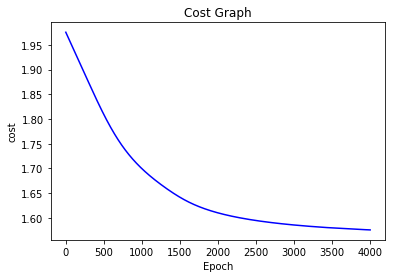

In [16]:
show_graph(graph_x, graph_y)

# 사용자 입력

In [17]:
x = [[7,0.27,0.36,20.7,0.045,45,170,1.0,3,0.45,8.8], # 6 
     [6.2,0.66,0.48,1.2,0.029,29,75,0.9892,3.33,0.39,12.8], # 8 
     [5.8,0.27,0.2,14.95,0.044,22,179,0.9962,3.37,0.37,10.2], # 5 
     [7.6,0.48,0.37,0.8,0.037,4,100,0.9902,3.03,0.39,11.4], # 4 
     [9.1,0.27,0.45,10.6,0.035,28,124,0.997,3.2,0.46,10.4], # 9 
     [10.3,0.17,0.47,1.4,0.037,5,33,0.9939,2.89,0.28,9.6], # 3 
     [8.3,0.27,0.45,1.3,0.048,8,72,0.9944,3.08,0.61,10.3], # 4
     [7.1,0.25,0.39,2.1,0.036,30,124,0.9908,3.28,0.43,12.2], # 8 
     [5.6,0.29,0.05,0.8,0.038,11,30,0.9924,3.36,0.35,9.2], # 5 
     [7.7,0.17,0.52,5.9,0.017,21,84,0.9929,3.14,0.4,11.9] # 7 
    ]
y = [6, 8, 5, 4, 9, 3, 4, 8, 5, 7]

x_input = pd.DataFrame(x, columns = x_columns)

for i in x_columns:
    norm(x_input, i)
    
x_input = x_input.values.tolist()

In [24]:
x = torch.FloatTensor(x)

x_ = Variable(x).cuda()

prediction = model.forward(x_)
_, output_index = torch.max(prediction, 1)

# print(prediction)
# print(output_index)
for i in range(len(output_index)):
    print("입력하신 quality는 : {} 이고, 실제값은 : {} 이다. 정답여부는 : {} 이다.".
          format(output_index[i]+3, y[i], output_index[i]+3 == y[i]))

입력하신 quality는 : 6 이고, 실제값은 : 6 이다. 정답여부는 : True 이다.
입력하신 quality는 : 6 이고, 실제값은 : 8 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 5 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 4 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 9 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 3 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 4 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 8 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 5 이다. 정답여부는 : False 이다.
입력하신 quality는 : 6 이고, 실제값은 : 7 이다. 정답여부는 : False 이다.
